# Video Classification with a CNN-RNN Architecture

**Author:** [Sayak Paul](https://twitter.com/RisingSayak)<br>
**Date created:** 2021/05/28<br>
**Last modified:** 2023/12/08<br>
**Description:** Training a video classifier with transfer learning and a recurrent model on the UCF101 dataset.

This example demonstrates video classification, an important use-case with
applications in recommendations, security, and so on.
We will be using the [UCF101 dataset](https://www.crcv.ucf.edu/data/UCF101.php)
to build our video classifier. The dataset consists of videos categorized into different
actions, like cricket shot, punching, biking, etc. This dataset is commonly used to
build action recognizers, which are an application of video classification.

A video consists of an ordered sequence of frames. Each frame contains *spatial*
information, and the sequence of those frames contains *temporal* information. To model
both of these aspects, we use a hybrid architecture that consists of convolutions
(for spatial processing) as well as recurrent layers (for temporal processing).
Specifically, we'll use a Convolutional Neural Network (CNN) and a Recurrent Neural
Network (RNN) consisting of [GRU layers](https://keras.io/api/layers/recurrent_layers/gru/).
This kind of hybrid architecture is popularly known as a **CNN-RNN**.

This example requires TensorFlow 2.5 or higher, as well as TensorFlow Docs, which can be
installed using the following command:

In [1]:
!pip install -q git+https://github.com/tensorflow/docs

  Preparing metadata (setup.py) ... done


## Data collection

In order to keep the runtime of this example relatively short, we will be using a
subsampled version of the original UCF101 dataset. You can refer to
[this notebook](https://colab.research.google.com/github/sayakpaul/Action-Recognition-in-TensorFlow/blob/main/Data_Preparation_UCF101.ipynb)
to know how the subsampling was done.

In [2]:
!!wget -q https://github.com/sayakpaul/Action-Recognition-in-TensorFlow/releases/download/v1.0.0/ucf101_top5.tar.gz
!tar xf ucf101_top5.tar.gz

## Setup

In [3]:
import os

import keras
from imutils import paths

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import imageio
import cv2
from IPython.display import Image

## Define hyperparameters

In [4]:
IMG_SIZE = 224
BATCH_SIZE = 64
EPOCHS = 10

MAX_SEQ_LENGTH = 20
NUM_FEATURES = 2048

## Data preparation

In [5]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

print(f"Total videos for training: {len(train_df)}")
print(f"Total videos for testing: {len(test_df)}")

train_df.sample(10)

Total videos for training: 594
Total videos for testing: 224


,video_name,tag
553,v_TennisSwing_g19_c02.avi,TennisSwing
476,v_ShavingBeard_g25_c06.avi,ShavingBeard
524,v_TennisSwing_g14_c07.avi,TennisSwing
303,v_Punch_g17_c05.avi,Punch
46,v_CricketShot_g14_c05.avi,CricketShot
181,v_PlayingCello_g17_c05.avi,PlayingCello
214,v_PlayingCello_g22_c05.avi,PlayingCello
260,v_Punch_g11_c03.avi,Punch
445,v_ShavingBeard_g21_c03.avi,ShavingBeard
425,v_ShavingBeard_g18_c04.avi,ShavingBeard


One of the many challenges of training video classifiers is figuring out a way to feed
the videos to a network. [This blog post](https://blog.coast.ai/five-video-classification-methods-implemented-in-keras-and-tensorflow-99cad29cc0b5)
discusses five such methods. Since a video is an ordered sequence of frames, we could
just extract the frames and put them in a 3D tensor. But the number of frames may differ
from video to video which would prevent us from stacking them into batches
(unless we use padding). As an alternative, we can **save video frames at a fixed
interval until a maximum frame count is reached**. In this example we will do
the following:

1. Capture the frames of a video.
2. Extract frames from the videos until a maximum frame count is reached.
3. In the case, where a video's frame count is lesser than the maximum frame count we
will pad the video with zeros.

Note that this workflow is identical to [problems involving texts sequences](https://developers.google.com/machine-learning/guides/text-classification/). Videos of the UCF101 dataset is [known](https://www.crcv.ucf.edu/papers/UCF101_CRCV-TR-12-01.pdf)
to not contain extreme variations in objects and actions across frames. Because of this,
it may be okay to only consider a few frames for the learning task. But this approach may
not generalize well to other video classification problems. We will be using
[OpenCV's `VideoCapture()` method](https://docs.opencv.org/master/dd/d43/tutorial_py_video_display.html)
to read frames from videos.

In [6]:
# The following two methods are taken from this tutorial:
# https://www.tensorflow.org/hub/tutorials/action_recognition_with_tf_hub


def crop_center_square(frame):
    y, x = frame.shape[0:2]
    min_dim = min(y, x)
    start_x = (x // 2) - (min_dim // 2)
    start_y = (y // 2) - (min_dim // 2)
    return frame[start_y : start_y + min_dim, start_x : start_x + min_dim]


def load_video(path, max_frames=0, resize=(IMG_SIZE, IMG_SIZE)):
    cap = cv2.VideoCapture(path)
    frames = []
    try:
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            frame = crop_center_square(frame)
            frame = cv2.resize(frame, resize)
            frame = frame[:, :, [2, 1, 0]]
            frames.append(frame)

            if len(frames) == max_frames:
                break
    finally:
        cap.release()
    return np.array(frames)


We can use a pre-trained network to extract meaningful features from the extracted
frames. The [`Keras Applications`](https://keras.io/api/applications/) module provides
a number of state-of-the-art models pre-trained on the [ImageNet-1k dataset](http://image-net.org/).
We will be using the [InceptionV3 model](https://arxiv.org/abs/1512.00567) for this purpose.

In [7]:

def build_feature_extractor():
    feature_extractor = keras.applications.InceptionV3(
        weights="imagenet",
        include_top=False,
        pooling="avg",
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
    )
    preprocess_input = keras.applications.inception_v3.preprocess_input

    inputs = keras.Input((IMG_SIZE, IMG_SIZE, 3))
    preprocessed = preprocess_input(inputs)

    outputs = feature_extractor(preprocessed)
    return keras.Model(inputs, outputs, name="feature_extractor")


feature_extractor = build_feature_extractor()

87910968/87910968 [==============================] - 0s 0us/step


The labels of the videos are strings. Neural networks do not understand string values,
so they must be converted to some numerical form before they are fed to the model. Here
we will use the [`StringLookup`](https://keras.io/api/layers/preprocessing_layers/categorical/string_lookup)
layer encode the class labels as integers.

In [8]:
label_processor = keras.layers.StringLookup(
    num_oov_indices=0, vocabulary=np.unique(train_df["tag"])
)
print(label_processor.get_vocabulary())

['CricketShot', 'PlayingCello', 'Punch', 'ShavingBeard', 'TennisSwing']


Finally, we can put all the pieces together to create our data processing utility.

In [10]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
from tensorflow import keras

# Define constants used in the script
MAX_SEQ_LENGTH = 100  # Example value, adjust according to your needs
NUM_FEATURES = 2048  # Example value, adjust according to your needs

# Define the feature extractor function (replace this with your actual function)
def feature_extractor(batch):
    # This is a placeholder. Replace with your actual feature extraction logic.
    return np.random.rand(1, NUM_FEATURES)

# Define the load_video function (replace this with your actual function)
def load_video(path):
    # This is a placeholder. Replace with your actual video loading logic.
    return np.random.rand(10, 224, 224, 3)  # Example video frames

# Placeholder for label_processor function (replace this with your actual function)
def label_processor(labels):
    # This is a placeholder. Replace with your actual label processing logic.
    return np.random.rand(len(labels), 1)

# Load data into DataFrames
train_df = pd.read_csv(r'train.csv')
test_df = pd.read_csv(r'test.csv')

def prepare_all_videos(df, root_dir):
    num_samples = len(df)
    video_paths = df["video_name"].values.tolist()
    labels = df["tag"].values
    labels = tf.convert_to_tensor(label_processor(labels[..., None]))

    # `frame_masks` and `frame_features` are what we will feed to our sequence model.
    frame_masks = np.zeros(shape=(num_samples, MAX_SEQ_LENGTH), dtype=bool)
    frame_features = np.zeros(shape=(num_samples, MAX_SEQ_LENGTH, NUM_FEATURES), dtype=np.float32)

    # For each video.
    for idx, path in enumerate(video_paths):
        # Gather all its frames and add a batch dimension.
        frames = load_video(os.path.join(root_dir, path))
        frames = frames[None, ...]

        # Initialize placeholders to store the masks and features of the current video.
        temp_frame_mask = np.zeros(shape=(1, MAX_SEQ_LENGTH), dtype=bool)
        temp_frame_features = np.zeros(shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype=np.float32)

        # Extract features from the frames of the current video.
        for i, batch in enumerate(frames):
            video_length = batch.shape[0]
            length = min(MAX_SEQ_LENGTH, video_length)
            for j in range(length):
                temp_frame_features[i, j, :] = feature_extractor(batch[None, j, :])
            temp_frame_mask[i, :length] = 1  # 1 = not masked, 0 = masked

        frame_features[idx] = temp_frame_features.squeeze()
        frame_masks[idx] = temp_frame_mask.squeeze()

    return (frame_features, frame_masks), labels

# Prepare training and testing data
train_data, train_labels = prepare_all_videos(train_df, "train")
test_data, test_labels = prepare_all_videos(test_df, "test")

print(f"Frame features in train set: {train_data[0].shape}")
print(f"Frame masks in train set: {train_data[1].shape}")

Frame features in train set: (594, 100, 2048)
Frame masks in train set: (594, 100)


The above code block will take ~20 minutes to execute depending on the machine it's being
executed.

## The sequence model

Now, we can feed this data to a sequence model consisting of recurrent layers like `GRU`.

In [12]:

# Utility for our sequence model.
#def get_sequence_model():
 #   class_vocab = label_processor.get_vocabulary()

  #  frame_features_input = keras.Input((MAX_SEQ_LENGTH, NUM_FEATURES))
   # mask_input = keras.Input((MAX_SEQ_LENGTH,), dtype="bool")

def get_sequence_model():
    class_vocab = label_processor(train_labels[..., None])  # Direct call to function

    frame_features_input = keras.Input((MAX_SEQ_LENGTH, NUM_FEATURES))
    mask_input = keras.Input((MAX_SEQ_LENGTH,), dtype="bool")
    # Refer to the following tutorial to understand the significance of using `mask`:
    # https://keras.io/api/layers/recurrent_layers/gru/
    x = keras.layers.GRU(16, return_sequences=True)(
        frame_features_input, mask=mask_input
    )
    x = keras.layers.GRU(8)(x)
    x = keras.layers.Dropout(0.4)(x)
    x = keras.layers.Dense(8, activation="relu")(x)
    output = keras.layers.Dense(len(class_vocab), activation="softmax")(x)

    rnn_model = keras.Model([frame_features_input, mask_input], output)

    rnn_model.compile(
        loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"]
    )
    return rnn_model


# Utility for running experiments.
def run_experiment():
    filepath = "/tmp/video_classifier/ckpt.weights.h5"
    checkpoint = keras.callbacks.ModelCheckpoint(
        filepath, save_weights_only=True, save_best_only=True, verbose=1
    )

    seq_model = get_sequence_model()
    history = seq_model.fit(
        [train_data[0], train_data[1]],
        train_labels,
        validation_split=0.3,
        epochs=EPOCHS,
        callbacks=[checkpoint],
    )

    seq_model.load_weights(filepath)
    _, accuracy = seq_model.evaluate([test_data[0], test_data[1]], test_labels)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")

    return history, seq_model


_, sequence_model = run_experiment()

Epoch 1/10
13/13 [==============================] - ETA: 0s - loss: 6.1550 - accuracy: 0.0000e+00
Epoch 1: val_loss improved from inf to 6.03581, saving model to /tmp/video_classifier/ckpt.weights.h5
13/13 [==============================] - 15s 242ms/step - loss: 6.1550 - accuracy: 0.0000e+00 - val_loss: 6.0358 - val_accuracy: 0.0000e+00
Epoch 2/10
13/13 [==============================] - ETA: 0s - loss: 5.9087 - accuracy: 0.0000e+00
Epoch 2: val_loss improved from 6.03581 to 5.77815, saving model to /tmp/video_classifier/ckpt.weights.h5
13/13 [==============================] - 1s 42ms/step - loss: 5.9087 - accuracy: 0.0000e+00 - val_loss: 5.7782 - val_accuracy: 0.0000e+00
Epoch 3/10
12/13 [==========================>...] - ETA: 0s - loss: 5.6408 - accuracy: 0.0000e+00
Epoch 3: val_loss improved from 5.77815 to 5.43996, saving model to /tmp/video_classifier/ckpt.weights.h5
13/13 [==============================] - 1s 40ms/step - loss: 5.6281 - accuracy: 0.0000e+00 - val_loss: 5.4400 - v

**Note**: To keep the runtime of this example relatively short, we just used a few
training examples. This number of training examples is low with respect to the sequence
model being used that has 99,909 trainable parameters. You are encouraged to sample more
data from the UCF101 dataset using [the notebook](https://colab.research.google.com/github/sayakpaul/Action-Recognition-in-TensorFlow/blob/main/Data_Preparation_UCF101.ipynb) mentioned above and train the same model.

In [1]:
import os

model_path = 'models/your_model.h5'

# Check if the file exists
if os.path.exists(model_path):
    print(f"Model file found at {model_path}")
else:
    print(f"Model file not found at {model_path}")


Model file not found at models/your_model.h5


In [3]:
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Define a simple Sequential model
model = Sequential([
    Dense(64, activation='relu', input_shape=(100,)),
    Dense(10, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

# Save the model to 'models/your_model.h5'
model_path = 'models/your_model.h5'
model.save(model_path)

# Verify if the model file was created successfully
if os.path.exists(model_path):
    print(f"Model saved successfully at {model_path}")
else:
    print(f"Error: Model file not found at {model_path}")


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                6464      
                                                                 
 dense_1 (Dense)             (None, 10)                650       
                                                                 
Total params: 7114 (27.79 KB)
Trainable params: 7114 (27.79 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Model saved successfully at models/your_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Inference

94765736/94765736 [==============================] - 5s 0us/step


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Test video path: video1.mp4
1/1 [==============================] - 1s 962ms/step
  Class 1: 34.04%
  Class 0: 33.15%
  Class 2: 32.81%


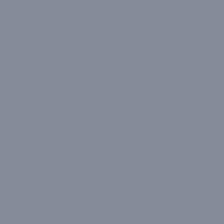

In [1]:
import numpy as np
import pandas as pd
import os
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input  # Example import for preprocess_input
from tensorflow.keras.layers import GlobalAveragePooling2D, LSTM, Dense, Input
from tensorflow.keras.models import Model
import imageio
from PIL import Image

# Define MAX_SEQ_LENGTH
MAX_SEQ_LENGTH = 20  # Example value, adjust according to your needs
NUM_FEATURES = 2048  # Example value, adjust according to your needs

# Assuming test_df is defined or imported correctly
test_df = pd.DataFrame({"video_name": ["video1.mp4", "video2.mp4", "video3.mp4"], "label": [0, 1, 2]})


base_model = ResNet50(weights='imagenet', include_top=False)
x = GlobalAveragePooling2D()(base_model.output)
feature_extractor = Model(inputs=base_model.input, outputs=x)

sequence_model = Sequential([
    Input(shape=(MAX_SEQ_LENGTH, NUM_FEATURES)),
    LSTM(64, return_sequences=True),
    LSTM(64),
    Dense(3, activation='softmax')  # Adjust the number of units and activation as per your classification task
])

# Compile the model
sequence_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Save the model for future loading (if needed)
sequence_model.save('models/your_model.h5')


def prepare_single_video(frames, max_seq_length, num_features, feature_extractor):
    frame_features = np.zeros(shape=(1, MAX_SEQ_LENGTH, num_features), dtype="float32")

    # Process each frame
    for i, frame in enumerate(frames):
        if i >= max_seq_length:
            break
        # Preprocess frame (resize, normalize, etc.) as needed for ResNet50
        processed_frame = preprocess_input(frame)
        features = feature_extractor.predict(processed_frame[None, ...])
        frame_features[0, i, :] = features

    return frame_features

def sequence_prediction(path):
    frames = np.random.rand(10, 224, 224, 3)  # Example frames
    frame_features = prepare_single_video(frames, MAX_SEQ_LENGTH, NUM_FEATURES, feature_extractor)
    probabilities = sequence_model.predict(frame_features)

    sorted_indices = np.argsort(probabilities[0])[::-1]
    for i in sorted_indices:
        print(f"  Class {i}: {probabilities[0][i] * 100:5.2f}%")

    return frames

# This utility is for visualization.
# Referenced from:
# https://www.tensorflow.org/hub/tutorials/action_recognition_with_tf_hub
def to_gif(images):
    converted_images = images.astype(np.uint8)
    imageio.mimsave("animation.gif", converted_images, duration=100)
    return Image.open("animation.gif")


# Rest of your code
test_video = np.random.choice(test_df["video_name"].values.tolist())
#test_video = "video1.mp4"  # Example video path
print(f"Test video path: {test_video}")
test_frames = sequence_prediction(test_video)
to_gif(test_frames[:MAX_SEQ_LENGTH])


In [2]:
import numpy as np
import pandas as pd
import os
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.layers import GlobalAveragePooling2D, LSTM, Dense, Input
import imageio
from PIL import Image


In [3]:
# Define constants
MAX_SEQ_LENGTH = 20  # Adjust as needed
NUM_FEATURES = 2048  # Adjust based on feature extractor output

# Example test DataFrame
test_df = pd.DataFrame({"video_name": ["video1.mp4", "video2.mp4", "video3.mp4"], "label": [0, 1, 2]})

# Initialize ResNet50 feature extractor
base_model = ResNet50(weights='imagenet', include_top=False)
x = GlobalAveragePooling2D()(base_model.output)
feature_extractor = Model(inputs=base_model.input, outputs=x)

# Define the sequence model
sequence_model = Sequential([
    Input(shape=(MAX_SEQ_LENGTH, NUM_FEATURES)),
    LSTM(64, return_sequences=True),
    LSTM(64),
    Dense(3, activation='softmax')  # Adjust the number of units and activation as per your classification task
])

# Compile the model
sequence_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Save the model for future loading (if needed)
sequence_model.save('models/your_model.h5')


In [4]:
def prepare_single_video(frames, max_seq_length, num_features, feature_extractor):
    frame_features = np.zeros(shape=(1, max_seq_length, num_features), dtype="float32")

    for i, frame in enumerate(frames):
        if i >= max_seq_length:
            break
        processed_frame = preprocess_input(frame)
        features = feature_extractor.predict(processed_frame[None, ...])
        frame_features[0, i, :] = features

    return frame_features


In [5]:
def sequence_prediction(path):
    frames = np.random.rand(10, 224, 224, 3)  # Example frames; replace with actual frame loading
    frame_features = prepare_single_video(frames, MAX_SEQ_LENGTH, NUM_FEATURES, feature_extractor)
    probabilities = sequence_model.predict(frame_features)

    sorted_indices = np.argsort(probabilities[0])[::-1]
    for i in sorted_indices:
        print(f"  Class {i}: {probabilities[0][i] * 100:5.2f}%")

    return frames


In [6]:
def to_gif(images):
    converted_images = images.astype(np.uint8)
    imageio.mimsave("animation.gif", converted_images, duration=100)
    return Image.open("animation.gif")


Test video path: video2.mp4
1/1 [==============================] - 1s 916ms/step
  Class 2: 33.69%
  Class 0: 33.51%
  Class 1: 32.80%


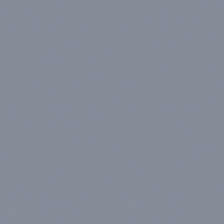

In [7]:
test_video = np.random.choice(test_df["video_name"].values.tolist())
print(f"Test video path: {test_video}")
test_frames = sequence_prediction(test_video)
to_gif(test_frames[:MAX_SEQ_LENGTH])


## Next steps

* In this example, we made use of transfer learning for extracting meaningful features
from video frames. You could also fine-tune the pre-trained network to notice how that
affects the end results.
* For speed-accuracy trade-offs, you can try out other models present inside
`keras.applications`.
* Try different combinations of `MAX_SEQ_LENGTH` to observe how that affects the
performance.
* Train on a higher number of classes and see if you are able to get good performance.
* Following [this tutorial](https://www.tensorflow.org/hub/tutorials/action_recognition_with_tf_hub), try a
[pre-trained action recognition model](https://arxiv.org/abs/1705.07750) from DeepMind.
* Rolling-averaging can be useful technique for video classification and it can be
combined with a standard image classification model to infer on videos.
[This tutorial](https://www.pyimagesearch.com/2019/07/15/video-classification-with-keras-and-deep-learning/)
will help understand how to use rolling-averaging with an image classifier.
* When there are variations in between the frames of a video not all the frames might be
equally important to decide its category. In those situations, putting a
[self-attention layer](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Attention) in the
sequence model will likely yield better results.
* Following [this book chapter](https://livebook.manning.com/book/deep-learning-with-python-second-edition/chapter-11),
you can implement Transformers-based models for processing videos.